### Sentiment Analysis on Movie Reviews
---

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

The sentiment labels are:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_train = pd.read_csv('Data/sentiment-train.tsv', sep='\t', header=0)
df_valid = pd.read_csv('Data/sentiment-test.tsv',  sep='\t', header=0)

In [3]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### Data Pre-Processing

As each sentence was parsed into many phrases, let's filter the complete phrase for each sentence first.

In [4]:
# df_train = df_train.sort_values(['SentenceId', 'PhraseId']).groupby(['SentenceId']).first().reset_index()
# df_valid = df_valid.sort_values(['SentenceId', 'PhraseId']).groupby(['SentenceId']).first().reset_index()

In [5]:
# df_train.head()

In [6]:
# df_valid.head()

### First Look at the Data

In [7]:
s = df_train['Sentiment'].value_counts()
s

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

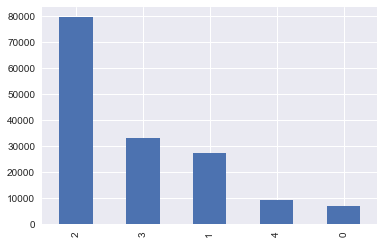

In [8]:
s.plot(kind='bar')

In [9]:
print('Negative:', s[0] + s[1])

Negative: 34345


In [10]:
print('Positive:', s[3] + s[4])

Positive: 42133


In [11]:
num_labels = len(df_train['Sentiment'].unique())

### More Pre-Processing

Before training any model, let's do more data pre-processing. Specifically, I'm goint to:

* Remove stop words
* Put all phrases in lower case
* Stem words

*PS: found that most of the code below can be done at once with [Keras](https://keras.io/preprocessing/text/) Tokenizer*

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

In [13]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}', '='])
stemmer = SnowballStemmer('english')

In [14]:
processed_docs_train = []
for df in [df_train, df_valid]:
    df['Parsed'] = df['Phrase'].apply(lambda x: x.lower())
    df['Parsed'] = df['Phrase'].apply(lambda x: word_tokenize(x))
    df['Parsed'] = df['Phrase'].apply(lambda x: [word for word in str(x).split() if word not in stop_words])
    df['Parsed'] = df['Parsed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [15]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Parsed
0,1,1,A series of escapades demonstrating the adage ...,1,"[a, seri, escapad, demonstr, adag, good, goos,..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[a, seri, escapad, demonstr, adag, good, goos]"
2,3,1,A series,2,"[a, seri]"
3,4,1,A,2,[a]
4,5,1,series,2,[seri]


In [16]:
df_valid.head()

,PhraseId,SentenceId,Phrase,Parsed
0,156061,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]"
1,156062,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]"
2,156063,8545,An,[an]
3,156064,8545,intermittently pleasing but mostly routine effort,"[intermitt, pleas, most, routin, effort]"
4,156065,8545,intermittently pleasing but mostly routine,"[intermitt, pleas, most, routin]"


Now, let's map each word to an ID...

In [17]:
from gensim import corpora

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [18]:
dictionary = corpora.Dictionary(df_train['Parsed'].values)

In [19]:
print ('Dictionary size:', len(dictionary)) 

Dictionary size: 11842


In [20]:
len(set(np.concatenate(df_train['Parsed'].values, axis=0)))

11842

In [21]:
# We have to skip words found in test but not in training data
diff = set(np.concatenate(df_valid['Parsed'].values, axis=0)) - set(np.concatenate(df_train['Parsed'].values, axis=0))

In [22]:
for df in [df_train, df_valid]:
    df['Dict'] = df['Parsed'].apply(lambda x: [dictionary.token2id[word] for word in x if word not in diff])

In [23]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Parsed,Dict
0,1,1,A series of escapades demonstrating the adage ...,1,"[a, seri, escapad, demonstr, adag, good, goos,...","[0, 1, 2, 3, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, ..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[a, seri, escapad, demonstr, adag, good, goos]","[0, 1, 2, 3, 4, 5, 6]"
2,3,1,A series,2,"[a, seri]","[0, 1]"
3,4,1,A,2,[a],[0]
4,5,1,series,2,[seri],[1]


In [24]:
df_valid.head()

,PhraseId,SentenceId,Phrase,Parsed,Dict
0,156061,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]","[575, 5848, 765, 908, 1343, 971]"
1,156062,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]","[575, 5848, 765, 908, 1343, 971]"
2,156063,8545,An,[an],[575]
3,156064,8545,intermittently pleasing but mostly routine effort,"[intermitt, pleas, most, routin, effort]","[5848, 765, 908, 1343, 971]"
4,156065,8545,intermittently pleasing but mostly routine,"[intermitt, pleas, most, routin]","[5848, 765, 908, 1343]"


### Model

#### Naive Bayes Classification

In [25]:
import nltk.classify.util

from nltk.classify import NaiveBayesClassifier

In [26]:
def word_feats(words):
    return dict([(word, True) for word in words])

In [27]:
features = [(word_feats(row['Parsed']), row['Sentiment']) for index, row in df_train.iterrows()]

cutoff = int(len(features)*3/4)
trainfeats = features[:cutoff]
validfeats = features[cutoff:]
classifier = NaiveBayesClassifier.train(trainfeats)

print('Accuracy:', nltk.classify.util.accuracy(classifier, validfeats))

classifier.show_most_informative_features()

Accuracy: 0.4217352300397283
Most Informative Features
                  atroci = True                0 : 2      =    186.6 : 1.0
                    crap = True                0 : 2      =    186.6 : 1.0
                unimagin = True                0 : 2      =    156.1 : 1.0
                88-minut = True                0 : 2      =    133.3 : 1.0
                  stupid = True                0 : 3      =    131.5 : 1.0
               indescrib = True                0 : 2      =    118.0 : 1.0
                    poor = True                0 : 3      =    117.9 : 1.0
                   dazzl = True                4 : 2      =    113.0 : 1.0
                  polish = True                4 : 2      =    109.6 : 1.0
                  redund = True                0 : 2      =    107.4 : 1.0


In [28]:
classifier = NaiveBayesClassifier.train(features)
classifier.show_most_informative_features()

Most Informative Features
                  atroci = True                0 : 2      =    183.8 : 1.0
                  insult = True                0 : 3      =    175.4 : 1.0
                88-minut = True                0 : 2      =    131.3 : 1.0
                  delici = True                4 : 2      =    129.7 : 1.0
                  devoid = True                0 : 3      =    128.8 : 1.0
                   worst = True                0 : 4      =    125.4 : 1.0
                  polish = True                4 : 2      =    123.9 : 1.0
                pretenti = True                0 : 3      =    116.4 : 1.0
               indescrib = True                0 : 2      =    116.3 : 1.0
                    wors = True                0 : 3      =    112.7 : 1.0


In [29]:
training = [word_feats(row['Parsed']) for index, row in df_valid.iterrows()]
y_pred = [classifier.classify(t) for t in training]

In [30]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)

#### Long Short-Term Memory

Now let's get ready to use an LSTM model...

In [31]:
mean = df_train['Dict'].apply(lambda x: len(x)).mean()

In [32]:
std = df_train['Dict'].apply(lambda x: len(x)).std()

In [33]:
print('Phrase size mean and std: {0:.2f},'.format(mean), '{0:.2f}'.format(std))

Phrase size mean and std: 4.26, 3.85


In [34]:
seq_len = np.round(mean + 2*std).astype(int)

In [35]:
print('Seq len:', seq_len)

Seq len: 12


In [36]:
X_train = df_train.drop(['Sentiment'], axis=1)
y_train = df_train['Sentiment']
X_valid = df_valid

In [37]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

In [38]:
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D

In [39]:
X_train = sequence.pad_sequences(np.array(X_train['Dict']), maxlen=seq_len)
X_valid = sequence.pad_sequences(np.array(X_valid['Dict']), maxlen=seq_len)

In [40]:
y_train = to_categorical(y_train)

In [41]:
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(len(dictionary), embedding_vector_length, input_length=seq_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

hist = model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_split=0.33)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 64)            757888    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 847,141
Trainable params: 847,141
Non-trainable params: 0
_________________________________________________________________
None
Train on 104560 samples, validate on 51500 samples
Epoch 1/5
63s - loss: 0.3525 - acc: 0.8482 - val_loss: 0.3493 - val_acc: 0.8438


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


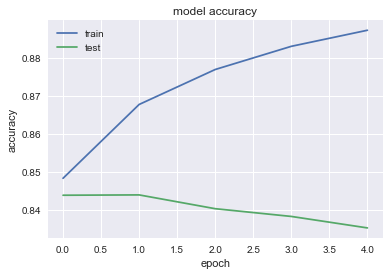

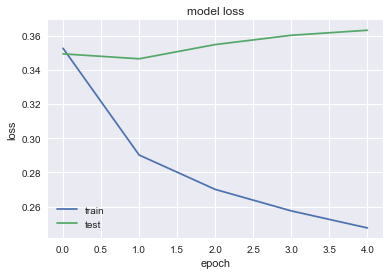

In [42]:
plot_history(hist)

In [43]:
y_pred = model.predict_classes(X_valid)

65984/66292 [============================>.] - ETA: 0s

In [44]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)